# **Project - TAAC/MECD/FEUP**
<br>
University of Porto - School of Engineering <br>
Master’s degree in Data Science & Engineering (MECD) – FEUP<br>
<br>
Advanced Topics in Computational Learning - TAAC<br>
December 2023 <br>
<br>
Authors: Paulo Portela (up202200871), Miguel Veloso (up202202463) and Jorge Vieira(up202204385)
<br>

# **Context**

Add context...

## **1. Library and Data Import**

In [3]:
!pip install inflect bs4 contractions torchtext wordcloud transformers datasets

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 12.9 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=becae99fc949a20d8ad5e75d1c2da410c20fecc01b1ddcd874d7af8ca2eaa0af
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4


In [16]:
import os
import pandas as pd
import numpy as np
import re
import sys
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict
from tabulate import tabulate
from tqdm import tqdm
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import contractions
from bs4 import BeautifulSoup
import inflect
import warnings
import random
import functools
from functools import partial
import math


#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchtext
from transformers import AutoModel, BertTokenizerFast, AutoTokenizer, pipeline, AdamW, RobertaModel, RobertaTokenizerFast, DistilBertTokenizer, DistilBertForMaskedLM, GPT2Tokenizer, GPT2Model
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler


# Download necessary NLTK data
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')


# Set of English stopwords
stop_words = set(stopwords.words("english"))

# Supress warnings (use with caution)
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## **2. Exploratory Data Analysis (EDA)**

### **2.1 Initial Data Analysis and Structure Overview**

In [ ]:
df = pd.read_csv('datasets/tweet_emotions.csv', delimiter=',')
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [ ]:
def basic_eda(df, row_limit=5, list_elements_limit=10):
    ### rows and columns
    print('Info : There are {} columns in the dataset'.format(df.shape[1]))
    print('Info : There are {} rows in the dataset'.format(df.shape[0]))

    print("==================================================")

    ## data types
    print("\nData type information of different columns")
    dtypes_df = pd.DataFrame(df.dtypes).reset_index().rename(columns={0:'dtype', 'index':'column_name'})
    cat_df = dtypes_df[dtypes_df['dtype']=='object']
    num_df = dtypes_df[dtypes_df['dtype']!='object']
    print('Info : There are {} categorical columns'.format(len(cat_df)))
    print('Info : There are {} numerical columns'.format(len(dtypes_df)-len(cat_df)))

    if list_elements_limit >= len(cat_df):
        print("Categorical columns : ", list(cat_df['column_name']))
    else:
        print("Categorical columns : ", list(cat_df['column_name'])[:list_elements_limit])

    if list_elements_limit >= len(num_df):
        print("Numerical columns : ", list(num_df['column_name']))
    else:
        print("Numerical columns : ", list(num_df['column_name'])[:list_elements_limit])

    #dtypes_df['dtype'].value_counts().plot.bar()
    display(dtypes_df.head(row_limit))

    print("==================================================")
    print("\nDescription of numerical variables")

    #### Describibg numerical columns
    desc_df_num = df[list(num_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_num.head(row_limit))

    print("==================================================")
    print("\nDescription of categorical variables")

    desc_df_cat = df[list(cat_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_cat.head(row_limit))

    return

In [ ]:
basic_eda(df)

Info : There are 3 columns in the dataset
Info : There are 40000 rows in the dataset

Data type information of different columns
Info : There are 2 categorical columns
Info : There are 1 numerical columns
Categorical columns :  ['sentiment', 'content']
Numerical columns :  ['tweet_id']


,column_name,dtype
0,tweet_id,int64
1,sentiment,object
2,content,object



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,tweet_id,40000.0,1.845184e+09,1.188579e+08,1.693956e+09,1.751431e+09,1.855443e+09,1.962781e+09,1.966441e+09



Description of categorical variables


,column_name,count,unique,top,freq
0,sentiment,40000,13,neutral,8638
1,content,40000,39827,I just received a mothers day card from my lov...,14


### **2.2 Check the existance and the number of Null Values and Duplicated**

In [ ]:
# Quickly check for mising values and duplicated
print(df.isnull().sum())
print("")
print(df.duplicated().sum())

tweet_id     0
sentiment    0
content      0
dtype: int64

0


### **2.3 Distribution of sentiments in the data and Balancing the Dataset**

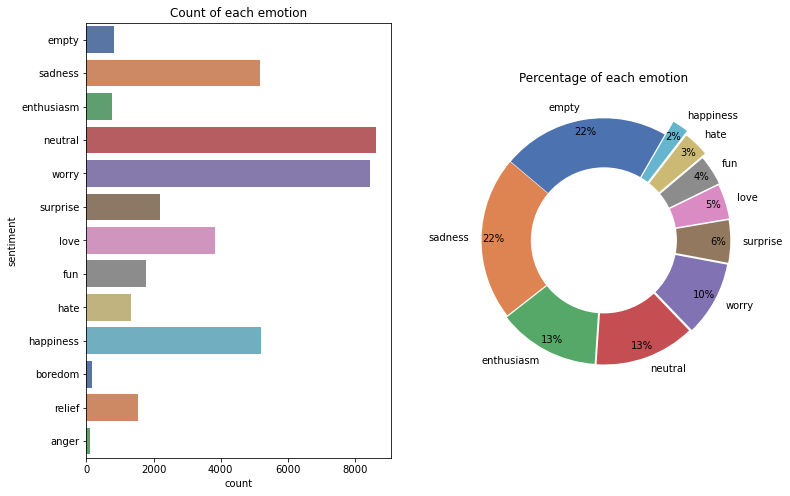

In [ ]:
col = 'sentiment'
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

# Simplified explode (optional, can adjust values or remove)
explode = [0.16] * 13

# Ensure labels and sizes match
labels = df[col].value_counts().index[:13]
sizes = df[col].value_counts().values[:13]

unique_sentiments = df[col].nunique()
palette = sns.color_palette("deep", unique_sentiments)

ax2.pie(sizes, explode=explode, startangle=10, labels=labels, autopct='%1.0f%%', pctdistance=0.9, colors=palette)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y=col, data=df, ax=ax1, palette=palette)
ax1.set_title("Count of each sentiment")
ax2.set_title("Percentage of each sentiment")
plt.show()

### **2.4 Analyzing Stopword Frequency in the Dataset**

Text(0, 0.5, 'Frequency')

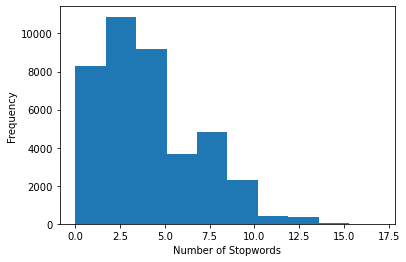

In [ ]:
#Count the number of stopwords in the data
temp =df.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['content'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

#distribution of stopwords visually
ax = temp['stop_words'].plot(kind='hist')
ax.set_xlabel('Number of Stopwords')
ax.set_ylabel('Frequency')

### **2.5 Overall Distribution of Character and Token Lengths**

In [ ]:
df['char_length'] = df['content'].apply(lambda x : len(x))
df['token_length'] = df['content'].apply(lambda x : len(x.split(" ")))

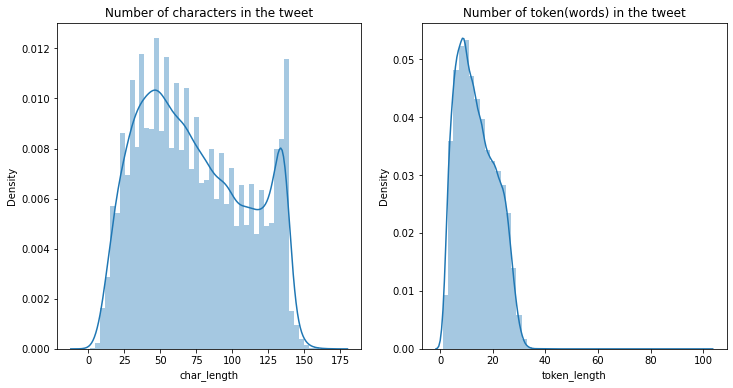

In [ ]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.distplot(df['char_length'], ax=ax1)
sns.distplot(df['token_length'], ax=ax2)
ax1.set_title('Number of characters in the tweet')
ax2.set_title('Number of token(words) in the tweet')
plt.show()

### **2.6 Character Length Distribution by Sentiment [Top 5 Sentiments]**

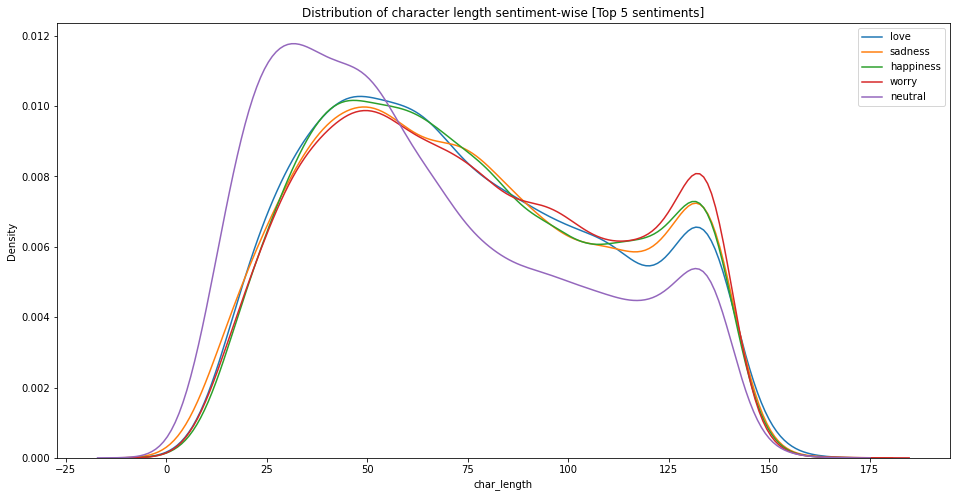

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
for sentiment in df['sentiment'].value_counts().sort_values()[-5:].index.tolist():
    #print(sentiment)
    sns.kdeplot(df[df['sentiment']==sentiment]['char_length'],ax=ax, label=sentiment)
ax.legend()
ax.set_title("Distribution of character length sentiment-wise [Top 5 sentiments]")
plt.show()

### **2.7 Distribution of Token Length by Sentiment [Top 5 Sentiments]**

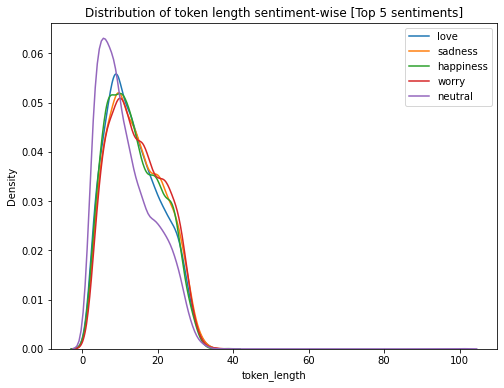

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
for sentiment in df['sentiment'].value_counts().sort_values()[-5:].index.tolist():
    #print(sentiment)
    sns.kdeplot(df[df['sentiment']==sentiment]['token_length'],ax=ax, label=sentiment)
ax.legend()
ax.set_title("Distribution of token length sentiment-wise [Top 5 sentiments]")
plt.show()

### **2.8 Exploring the Most Frequent Character and Token Lengths**

In [ ]:
avg_df = df.groupby('sentiment').agg({'char_length':'mean', 'token_length':'mean'})

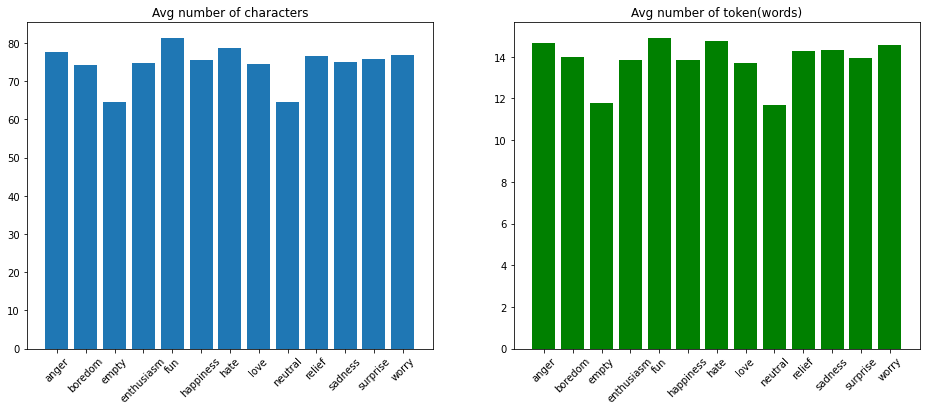

In [ ]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.bar(avg_df.index, avg_df['char_length'])
ax2.bar(avg_df.index, avg_df['token_length'], color='green')
ax1.set_title('Avg number of characters')
ax2.set_title('Avg number of token(words)')
ax1.set_xticklabels(avg_df.index, rotation = 45)
ax2.set_xticklabels(avg_df.index, rotation = 45)
plt.show()

**Findings**

- The dataset encompasses 13 distinct emotions;
- "Neutral" and "Worry" emerge as the predominant emotions;
- The character count in most tweets averages about 45;
- The token length commonly peaks at approximately 10;
- Individuals expressing "empty" and "neutral" emotions tend to compose shorter tweets.

## **3. Text Preprocessing**

## **3.1 Management and Removal of Duplicates with Divergent Emotions in Texts**

In [ ]:
# Grouping by 'content' and listing the unique emotions for each group
grouped_emotions = df.groupby('content')['sentiment'].unique()

# Filtering out groups with more than one unique emotion
duplicates_with_different_emotions = grouped_emotions[grouped_emotions.apply(lambda x: len(x) > 1)]

# Converting arrays of emotions into strings
duplicates_with_different_emotions_str = duplicates_with_different_emotions.apply(lambda x: ', '.join(x))

# For display using tabulate
duplicates_list = duplicates_with_different_emotions_str.reset_index().values.tolist()

# Displaying the result
print(len(duplicates_with_different_emotions))
print(tabulate(duplicates_list, headers=['Content', 'Different Emotions'], tablefmt='fancy_grid'))

62
╒══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════╕
│ Content                                                                                                                                  │ Different Emotions                                       │
╞══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════╡
│ 0                                                                                                                                        │ empty, neutral                                           │
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────

In [ ]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df[df['content'].duplicated() == True]

,tweet_id,sentiment,content
366,1957048870,worry,I feel so deflated. No more doggy.
521,1957088574,worry,Somebody please save the polar bears!
1026,1957198430,neutral,I'm at work
3684,1958103183,sadness,@dublins98dave me too! I am down 400 euro
4363,1960336689,worry,"is upset, I left my phone at home again"
...,...,...,...
39859,1753886681,love,Happy Mothers Day
39898,1753902524,love,happy mothers day!
39913,1753902827,happiness,happy mother's day!
39915,1753903008,love,happy mother's day everyone


In [ ]:
df[df['content'] == df.iloc[366]['content']]

,tweet_id,sentiment,content
324,1957039922,sadness,I feel so deflated. No more doggy.
366,1957048870,worry,I feel so deflated. No more doggy.


In [ ]:
#removing duplicated text
index = df[df['content'].duplicated() == True].index
df.drop(index, axis = 0, inplace = True)
df.reset_index(inplace=True, drop = True)

## **3.2 Different Approaches to Data Balancing**

In [ ]:
df_train,df_test = train_test_split(df, test_size=0.2,random_state = 123)

### **3.2.1 Synonym Replacement**

In [ ]:
target_class = 'neutral'

# Filter out the target class
df_target_class = df_train[df_train['sentiment'] == target_class]

# Randomly sample 5000 images from the target class
df_target_class_downsampled = df_target_class.sample(n=5300, random_state=42)

# Remove the original target class data from the dataframe
df_train = df_train[df_train['sentiment'] != target_class]

# Append the downsampled data
df_train = df_train.append(df_target_class_downsampled, ignore_index=True)

In [ ]:
target_class = 'worry'

# Filter out the target class
df_target_class = df_train[df_train['sentiment'] == target_class]

# Randomly sample 5000 images from the target class
df_target_class_downsampled = df_target_class.sample(n=5300, random_state=42)

# Remove the original target class data from the dataframe
df_train = df_train[df_train['sentiment'] != target_class]

# Append the downsampled data
df_train = df_train.append(df_target_class_downsampled, ignore_index=True)

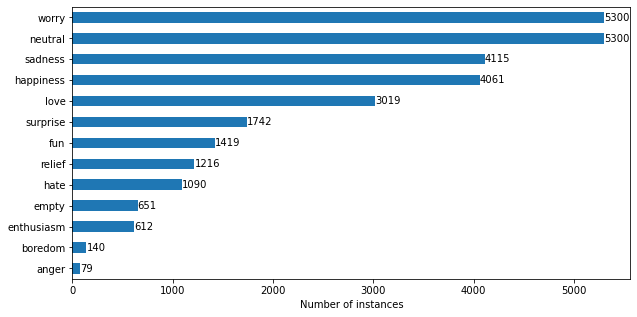

In [ ]:
ax = df_train.sentiment.value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
ax.bar_label(ax.containers[0])
ax.set_xlabel('Number of instances')
plt.show()

In [ ]:
def synonym_replacement(sentence, n=2):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word.isalpha()]))
    random.shuffle(random_word_list)
    num_replaced = 0

    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)

        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1

        if num_replaced >= n:  # Only replace up to n words
            break

    sentence = ' '.join(new_words)
    return sentence

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char.isalpha()])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

n_augmentations = 5300  # Total number of new sentences to generate for each target class

for label in df_train['sentiment'].unique():
    if label not in ['worry', 'neutral']:
        target_class = label
        print('label: ' + label + '\n')

        # Filter samples from this class
        class_samples = df_train[df_train['sentiment'] == label]

        # Calculate how many samples to generate
        samples_to_generate = n_augmentations - class_samples.shape[0]

        generated_count = 0
        while generated_count < samples_to_generate:
            row = class_samples.sample(n=1).iloc[0]  # Randomly select a row to augment
            new_sentence = synonym_replacement(row['content'])
            df_train = df_train.append({'content': new_sentence, 'sentiment': target_class}, ignore_index=True)
            generated_count += 1

df_train.to_csv('datasets/augdf_Syn.csv', index=False)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jorgevieira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jorgevieira/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jorgevieira/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


label: surprise

label: sadness

label: anger

label: fun

label: happiness

label: empty

label: hate

label: love

label: enthusiasm

label: relief

label: boredom



### **3.2.2 Contextualized Word Embedding Replacement**

In [ ]:
# Load DistilBERT model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForMaskedLM.from_pretrained('distilbert-base-uncased')

def distilbert_augmentation(sentence):
    # Tokenize the input sentence and convert to tensor
    inputs = tokenizer.encode_plus(sentence, return_tensors='pt')
    input_ids = inputs['input_ids']

    # Choose a random word (token) to mask, excluding CLS and SEP tokens
    token_indices = [i for i, token in enumerate(input_ids[0]) if token not in (tokenizer.cls_token_id, tokenizer.sep_token_id)]
    rand_index = random.choice(token_indices)

    # Replace the chosen token with the mask token
    masked_input_ids = input_ids.clone()
    masked_input_ids[0][rand_index] = tokenizer.mask_token_id

    with torch.no_grad():
        outputs = model(masked_input_ids)

    predictions = outputs.logits
    masked_word_predictions = predictions[0, rand_index]

    # Get the top prediction for the masked word
    predicted_index = torch.argmax(masked_word_predictions).item()
    predicted_token = tokenizer.decode([predicted_index])

    # Replace the masked word in the original sentence
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    tokens[rand_index] = predicted_token
    return tokenizer.convert_tokens_to_string(tokens)


n_augmentations = 5300  # Total number of new sentences to generate for each target class

for label in df_train['sentiment'].unique():
    if label not in ['worry', 'neutral']:
        target_class = label
        print('label: ' + label + '\n')

        # Filter samples from this class
        class_samples = df_train[df_train['sentiment'] == label]

        # Calculate how many samples to generate
        samples_to_generate = n_augmentations - class_samples.shape[0]

        generated_count = 0
        while generated_count < samples_to_generate:
            row = class_samples.sample(n=1).iloc[0]  # Randomly select a row to augment
            new_sentence = distilbert_augmentation(row['content'])
            df_train = df_train.append({'content': new_sentence, 'sentiment': target_class}, ignore_index=True)
            generated_count += 1

df_train.to_csv('datasets/augdf_Cont.csv', index=False)

## **3.3 Loading Diverse Datasets**

### **3.3.1 Load Dataset with Synonym Substitution**

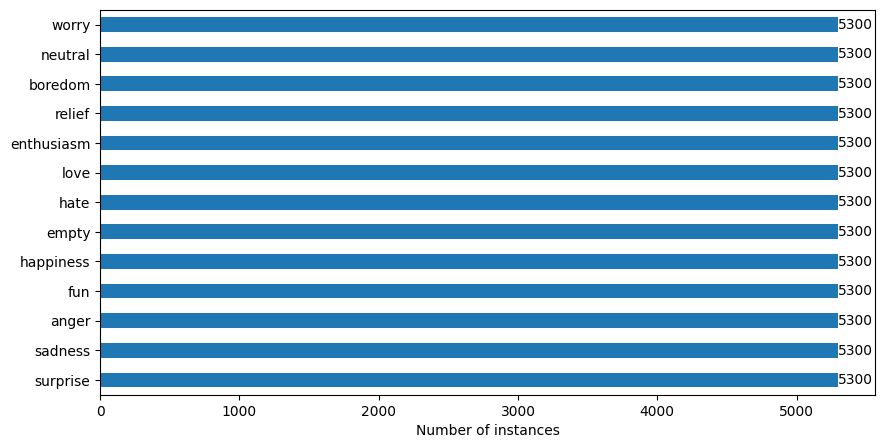

In [5]:
df = pd.read_csv('datasets/augdf_Syn.csv', delimiter=',')
df.head()

ax = df.sentiment.value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
ax.bar_label(ax.containers[0])
ax.set_xlabel('Number of instances')
plt.show()

### **3.3.2 Load Dataset with Contextualized Word Embedding (distilbert) substitution**

In [ ]:
df = pd.read_csv('datasets/augdf_Cont.csv', delimiter=',')
df.head()

ax = df.sentiment.value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
ax.bar_label(ax.containers[0])
ax.set_xlabel('Number of instances')
plt.show()

## **3.4 Data preparation, cleanning and text-preprocessing**

In [6]:
def text_preprocessing_platform(df, text_col, remove_stopwords=True):

    ## Define functions for individual steps
    # First function is used to denoise text
    def denoise_text(text):
        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text

    ## Next step is text-normalization

    # Text normalization includes many steps.

    # Each function below serves a step.


    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words


    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words


    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words


    def replace_numbers(words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words


    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in stopwords.words('english'):
                new_words.append(word)
        return new_words


    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems


    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas


    ### A wrap-up function for normalization
    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = to_lowercase(words)
        words = remove_punctuation(words)
        words = replace_numbers(words)
        if remove_stopwords:
            words = remove_stopwords(words)
        #words = stem_words(words)
        words = lemmatize_verbs(words)
        return words

    # All above functions work on word tokens we need a tokenizer

    # Tokenize tweet into words
    def tokenize(text):
        return nltk.word_tokenize(text)


    # A overall wrap-up function
    def text_prepare(text):
        text = denoise_text(text)
        text = ' '.join([x for x in normalize_text(tokenize(text), remove_stopwords)])
        return text

    # run every-step
    df[text_col] = [text_prepare(x) for x in df[text_col]]


    # return processed df
    return df

In [9]:
print("Before Text Preprocessing")
display(df.head()[['content']])
df = text_preprocessing_platform(df, 'content', remove_stopwords=False)
print("After Text Preprocessing")
display(df.head()[['content']])

Before Text Preprocessing


,content
0,@mahhsaayyy imagine i would say&quot;bitch!&qu...
1,I'm bored. I have a headache.
2,"@wmdev Every time I succeed with a code, I get..."
3,It's Going To Be A Busy Day And That Sucks Ca...
4,Playing cards with my niece.


After Text Preprocessing


,content
0,mahhsaayyy imagine would say bitch lol haha cu...
1,bore headache
2,wmdev every time succeed code get sorry credit...
3,go busy day suck want spend time someone earli...
4,play card niece


## **3.5 Uni-gram Analysis**

In [ ]:
def print_word_cloud(df, sentiment):

    print("Word cloud of most frequent words for the sentiment : {}".format(sentiment))

    temp_df = df[df['sentiment']==sentiment]
    print("Number of Rows : ", len(temp_df))

    corpus = ''
    for text in temp_df.content:
        text = str(text)
        corpus += text

    total = 0
    count = defaultdict(lambda: 0)
    for word in corpus.split(" "):
        total += 1
        count[word] += 1

    top20pairs = sorted(count.items(), key=lambda kv: kv[1], reverse=True)[:20]
    top20words = [i[0] for i in top20pairs]
    top20freq = [i[1] for i in top20pairs]

    xs = np.arange(len(top20words))
    width = 0.5

    fig = plt.figure(figsize=(10,6))
    ax = fig.gca()  #get current axes
    ax.bar(xs, top20freq, width, align='center')

    ax.set_xticks(xs)
    ax.set_xticklabels(top20words)
    plt.xticks(rotation=45)


    stopwords = set(STOPWORDS)
    # lower max_font_size, change the maximum number of word and lighten the background:
    wordcloud = WordCloud(max_font_size=50, max_words=50,stopwords=stopwords, background_color="white").generate(corpus)
    plt.figure(figsize = (12, 12), facecolor = None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Word cloud of most frequent words for the sentiment : sadness
Number of Rows :  5300


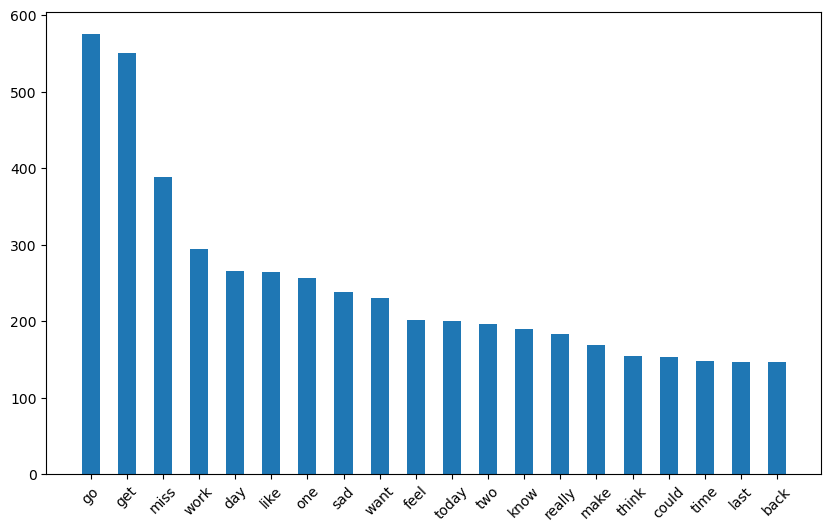

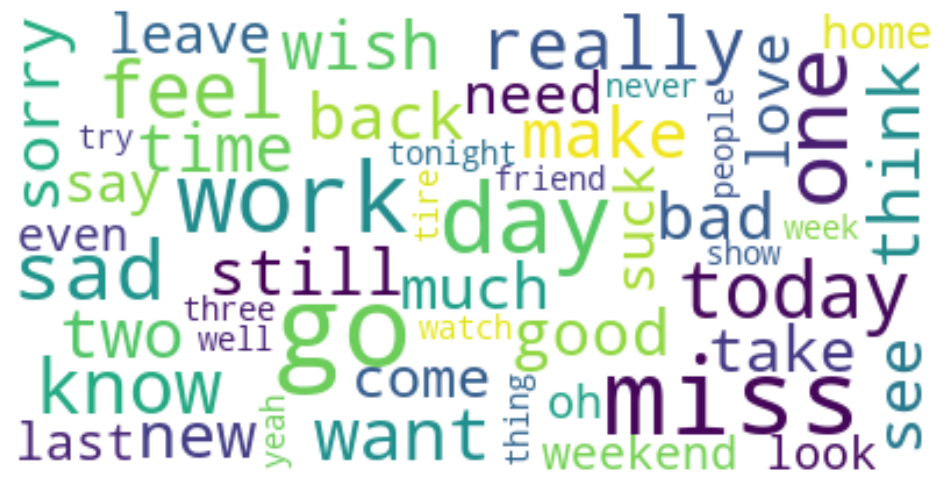

In [ ]:
print_word_cloud(df, 'sadness')

Word cloud of most frequent words for the sentiment : happiness
Number of Rows :  5209


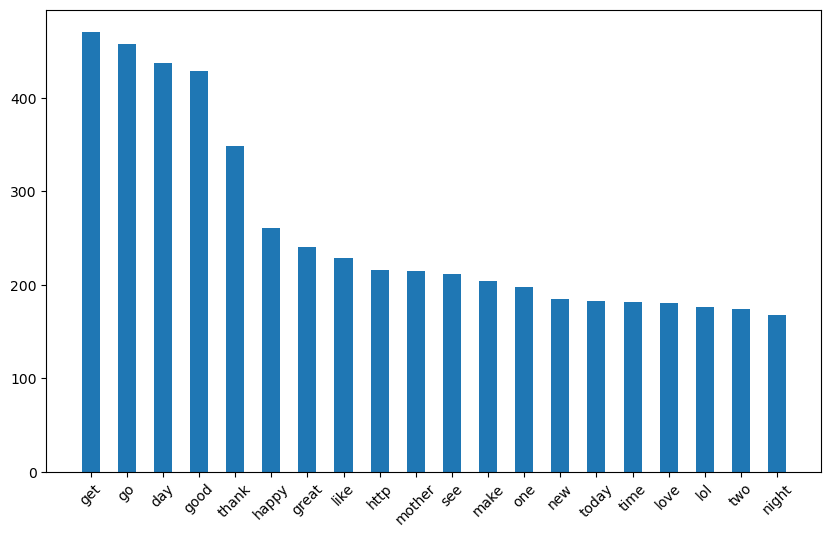

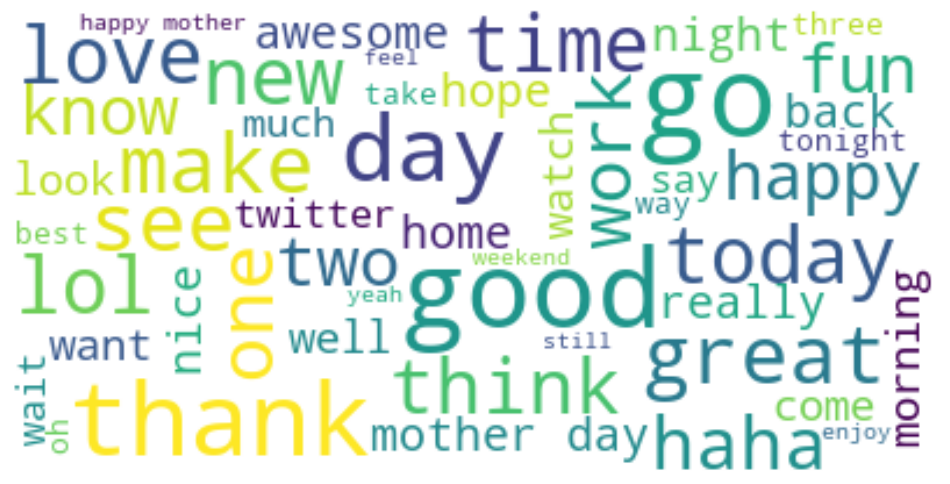

In [ ]:
print_word_cloud(df, 'happiness')

Word cloud of most frequent words for the sentiment : worry
Number of Rows :  8459


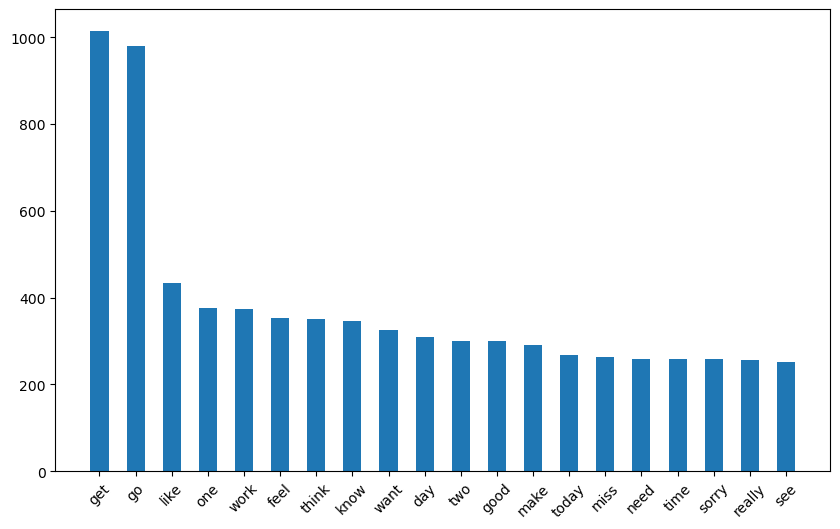

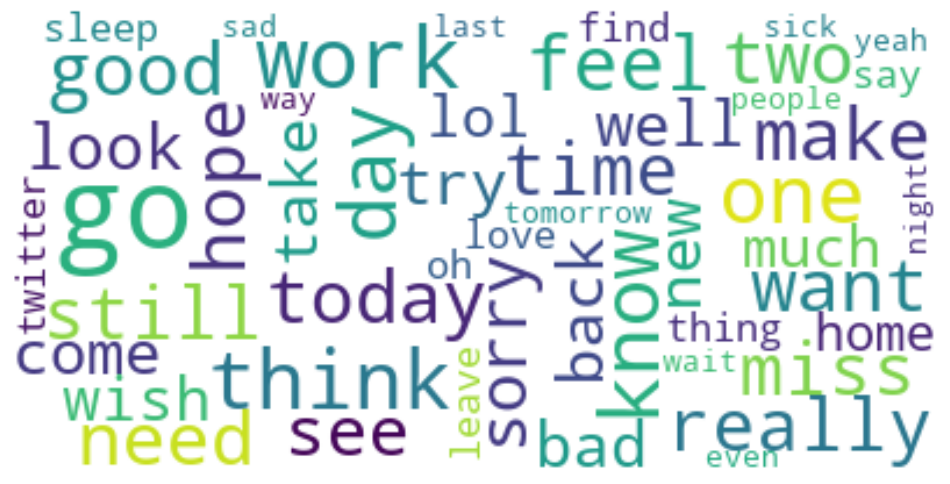

In [ ]:
print_word_cloud(df, 'worry')

Word cloud of most frequent words for the sentiment : neutral
Number of Rows :  8638


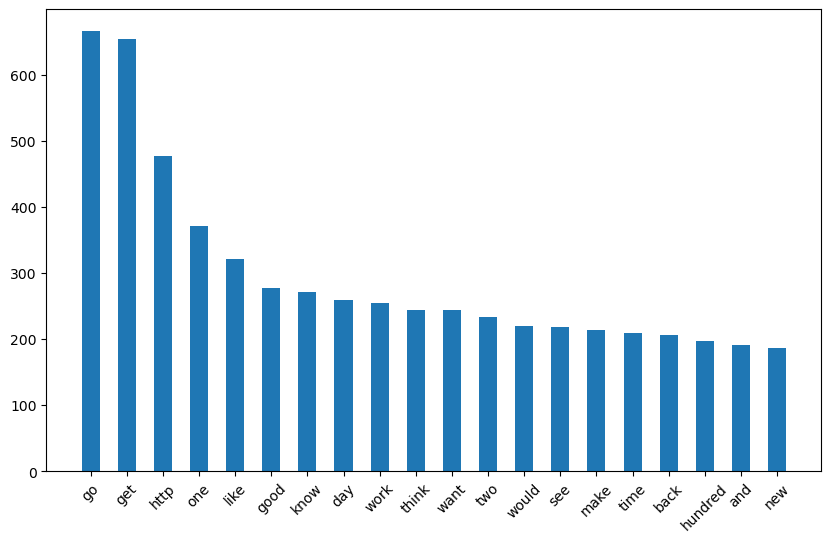

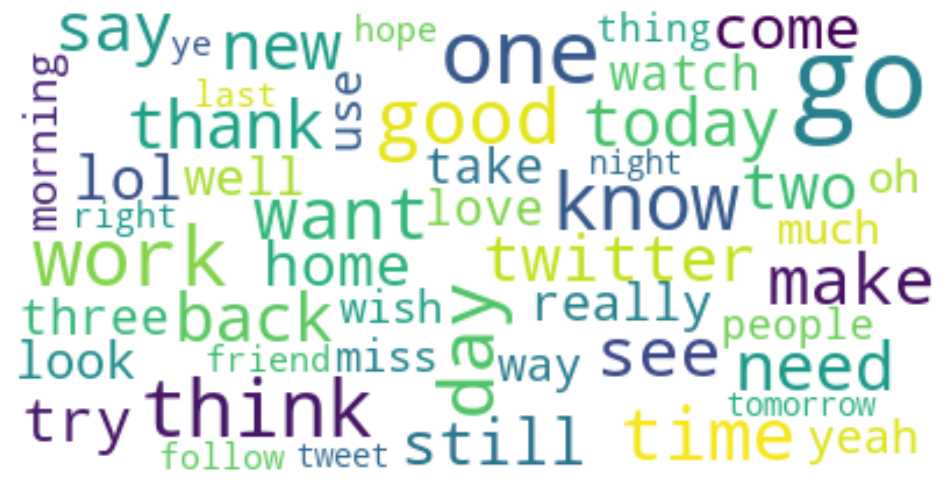

In [ ]:
print_word_cloud(df, 'neutral')

Word cloud of most frequent words for the sentiment : other
Number of Rows :  8687


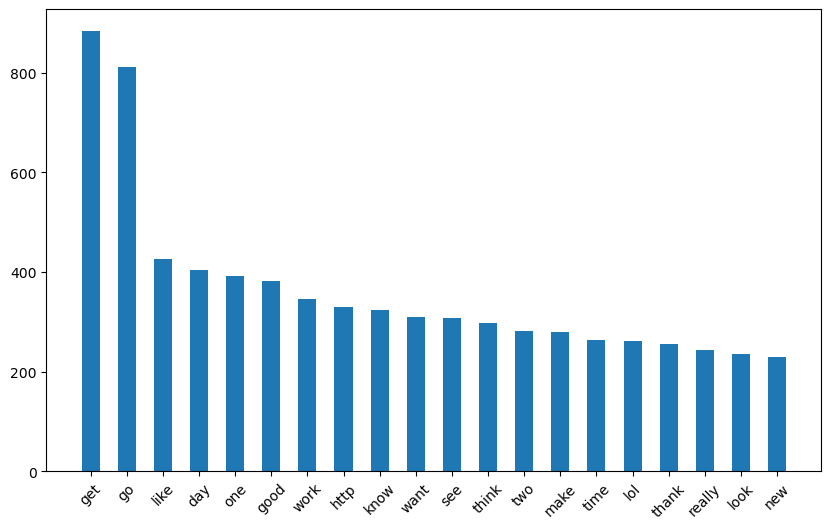

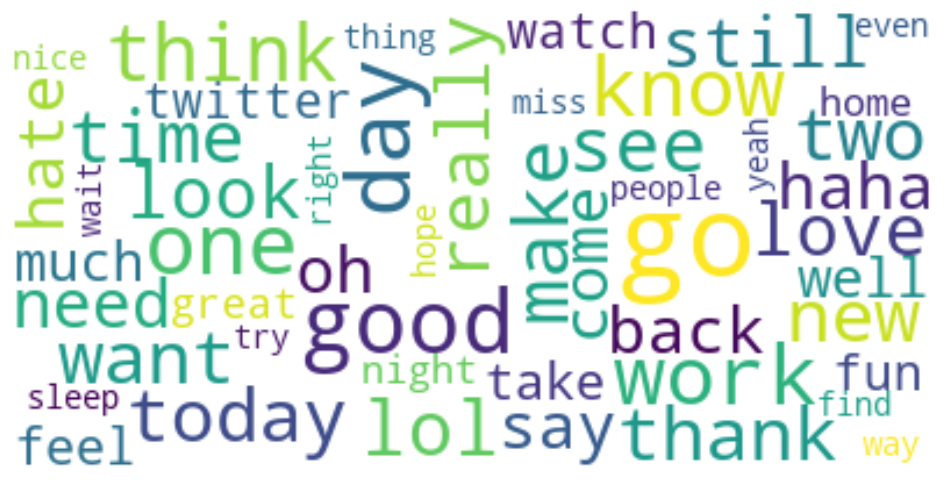

In [ ]:
print_word_cloud(df, 'other')

# **4. Exploring Advanced Neural Network Architectures**

In [63]:
#Split df into train, test and validation
X = df['content']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123, stratify=y_train)

print("Train set size : ", X_train.shape)
print("Test set size : ", X_test.shape)
print("Validation set size : ", X_val.shape)

# Rebuilding the DataFrames
df_train = pd.DataFrame({'content': X_train, 'sentiment': y_train})
df_test = pd.DataFrame({'content': X_val, 'sentiment': y_val})
df_val = pd.DataFrame({'content': X_test, 'sentiment': y_test})

Train set size :  (44096,)
Test set size :  (13780,)
Validation set size :  (11024,)


In [64]:
class_names = ['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness',
       'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise',
       'worry']

In [12]:
# This 'conf_matrix' function is used to create a confusion matrix visualization to evaluate the performance of a classification model
def conf_matrix(y, y_pred, labels, title):
    fig, ax =plt.subplots(figsize=(10,10))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":15})
    ax.xaxis.set_ticklabels(labels, fontsize=10)
    ax.yaxis.set_ticklabels(labels, fontsize=10)
    plt.title(title, fontsize=20)
    ax.set_ylabel('Test', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    plt.show()

## **4.1 Recurrent Architectures: Beyond the Basics**

In [13]:
# Check if CUDA is available and set the device to GPU if it is
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [14]:
# Renaming columns and preparing data for training and testing
df_train.rename(columns={'content': 'text', 'sentiment': 'label'}, inplace=True)
df_test.rename(columns={'content': 'text', 'sentiment': 'label'}, inplace=True)

label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['label'])
df_test['label'] = label_encoder.transform(df_test['label'])

df_train_dict = {
    "text": df_train['text'].tolist(),
    "label": df_train['label'].tolist()
}

df_test_dict = {
    "text": df_test['text'].tolist(),
    "label": df_test['label'].tolist()
}

train_data = Dataset.from_dict(df_train_dict)
test_data = Dataset.from_dict(df_test_dict)

In [17]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

def tokenize_data(example, tokenizer, max_length):
    tokens = tokenizer(example['text'])[:max_length]
    length = len(tokens)
    return {'tokens': tokens, 'length': length}

In [18]:
max_length = 256

train_data = train_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})
test_data = test_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})

Map:   0%|          | 0/44096 [00:00<?, ? examples/s]

Map:   0%|          | 0/11024 [00:00<?, ? examples/s]

In [19]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data['train']
valid_data = train_valid_data['test']

In [20]:
min_freq = 5
special_tokens = ['<unk>', '<pad>']

vocab = torchtext.vocab.build_vocab_from_iterator(train_data['tokens'],
                                                  min_freq=min_freq,
                                                  specials=special_tokens)

unk_index = vocab['<unk>']
pad_index = vocab['<pad>']

vocab.set_default_index(unk_index)

In [21]:
def numericalize_data(example, vocab):
    ids = [vocab[token] for token in example['tokens']]
    return {'ids': ids}

train_data = train_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
valid_data = valid_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
test_data = test_data.map(numericalize_data, fn_kwargs={'vocab': vocab})

Map:   0%|          | 0/33072 [00:00<?, ? examples/s]

Map:   0%|          | 0/11024 [00:00<?, ? examples/s]

Map:   0%|          | 0/11024 [00:00<?, ? examples/s]

In [22]:
train_data = train_data.with_format(type='torch', columns=['ids', 'label', 'length'])
valid_data = valid_data.with_format(type='torch', columns=['ids', 'label', 'length'])
test_data = test_data.with_format(type='torch', columns=['ids', 'label', 'length'])

train_data[0]

{'label': tensor(4),
 'length': tensor(15),
 'ids': tensor([2420,   86,  188, 3394, 1320,  188,  235,   91,  188, 2080,  839,   38,
         2075, 1952,    2])}

### **4.1.1 Long Short-Term Memory (LSTM)**

In [23]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional,
                 dropout_rate, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional,
                            dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, length, batch_first=True,
                                                            enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [24]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique('label'))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate,
             pad_index)

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,492,713 trainable parameters


In [26]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,492,713 trainable parameters


In [27]:
model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(6251, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=13, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [28]:
vectors = torchtext.vocab.FastText()

pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

model.embedding.weight.data = pretrained_embedding

lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

.vector_cache/wiki.en.vec: 6.60GB [01:00, 109MB/s]                             
100%|██████████| 2519370/2519370 [07:16<00:00, 5767.41it/s]


In [29]:
def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_length = [i['length'] for i in batch]
    batch_length = torch.stack(batch_length)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'length': batch_length,
             'label': batch_label}
    return batch

batch_size = 512

collate = functools.partial(collate, pad_index=pad_index)

train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               collate_fn=collate,
                                               shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

In [30]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        length = batch['length']
        label = batch['label'].to(device)

        # Adding length check
        if any(l <= 0 for l in length):
            continue  # Ignore this batch if there are zero-length sequences

        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy)

    return epoch_losses, epoch_accs

def evaluate(dataloader, model, criterion, optimizer, device, class_names):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            length = batch['length']
            label = batch['label'].to(device)

            # Adding length check
            if any(l <= 0 for l in length):
                continue  # Ignore this batch if there are zero-length sequences

            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy)

            # Convert the predictions back to the original classes
            predicted_classes = [class_names[pred_idx] for pred_idx in prediction.argmax(dim=1).cpu().tolist()]
            true_classes = [class_names[label_idx] for label_idx in label.cpu().tolist()]

            predicted_labels.extend(predicted_classes)
            true_labels.extend(true_classes)

    return epoch_losses, epoch_accs, true_labels, predicted_labels # Return the real labels and forecasts


def get_accuracy(prediction, label):
    # Converting predictions into classes
    predicted_classes = prediction.argmax(dim=1)

    # Calculating the number of correct predictions
    correct_predictions = (predicted_classes == label).sum().item()

    # Calculating accuracy
    accuracy = correct_predictions / len(label)
    return accuracy

Epoch: 1
evaluating...: 100%|██████████| 22/22 [00:00<00:00, 22.92it/s]
Train Loss: 2.463, Train Accuracy: 0.149
Valid Loss: 2.264, Valid Accuracy: 0.242
Epoch: 2
evaluating...: 100%|██████████| 22/22 [00:00<00:00, 24.68it/s]
Train Loss: 2.121, Train Accuracy: 0.286
Valid Loss: 1.943, Valid Accuracy: 0.355
Epoch: 3
evaluating...: 100%|██████████| 22/22 [00:00<00:00, 23.73it/s]
Train Loss: 1.900, Train Accuracy: 0.356
Valid Loss: 1.818, Valid Accuracy: 0.395
Epoch: 4
evaluating...: 100%|██████████| 22/22 [00:00<00:00, 24.11it/s]
Train Loss: 1.772, Train Accuracy: 0.400
Valid Loss: 1.725, Valid Accuracy: 0.420
Epoch: 5
evaluating...: 100%|██████████| 22/22 [00:01<00:00, 15.62it/s]
Train Loss: 1.671, Train Accuracy: 0.436
Valid Loss: 1.676, Valid Accuracy: 0.437
Epoch: 6
evaluating...: 100%|██████████| 22/22 [00:00<00:00, 24.42it/s]
Train Loss: 1.603, Train Accuracy: 0.457
Valid Loss: 1.625, Valid Accuracy: 0.459
Epoch: 7
evaluating...: 100%|██████████| 22/22 [00:00<00:00, 23.74it/s]
Trai

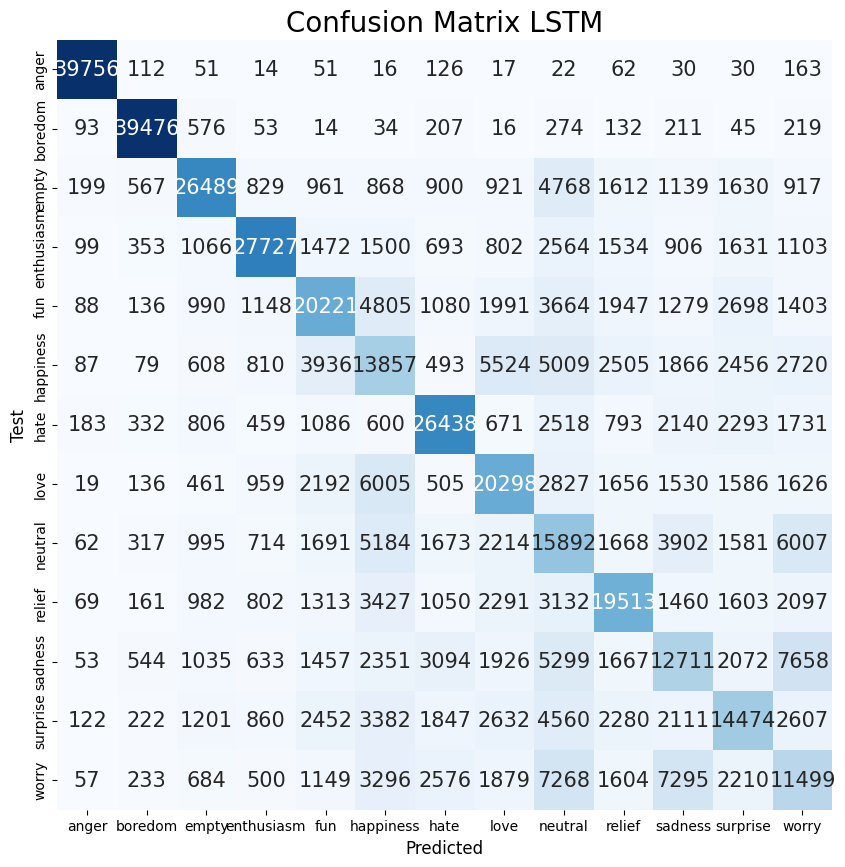

In [31]:
n_epochs = 50
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
all_true_labels = []
all_predicted_labels = []

for epoch in range(n_epochs):

    print(f'Epoch: {epoch+1}')

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc, true_labels, predicted_labels = evaluate(valid_dataloader, model, criterion, optimizer, device, class_names)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'models/lstm_50.pt')

    all_true_labels.extend(true_labels)
    all_predicted_labels.extend(predicted_labels)


    print(f'Train Loss: {epoch_train_loss:.3f}, Train Accuracy: {epoch_train_acc:.3f}')
    print(f'Valid Loss: {epoch_valid_loss:.3f}, Valid Accuracy: {epoch_valid_acc:.3f}')

# After the training is finished, you can calculate the classification report and the confusion matrix using the true labels and predictions from all epochs
classification_report_str = classification_report(all_true_labels, all_predicted_labels)

# Print the classification report
print("Classification Report:")
print(classification_report_str)

conf_matrix(all_true_labels, all_predicted_labels, class_names, "Confusion Matrix LSTM")

Text(0, 0.5, 'Loss')

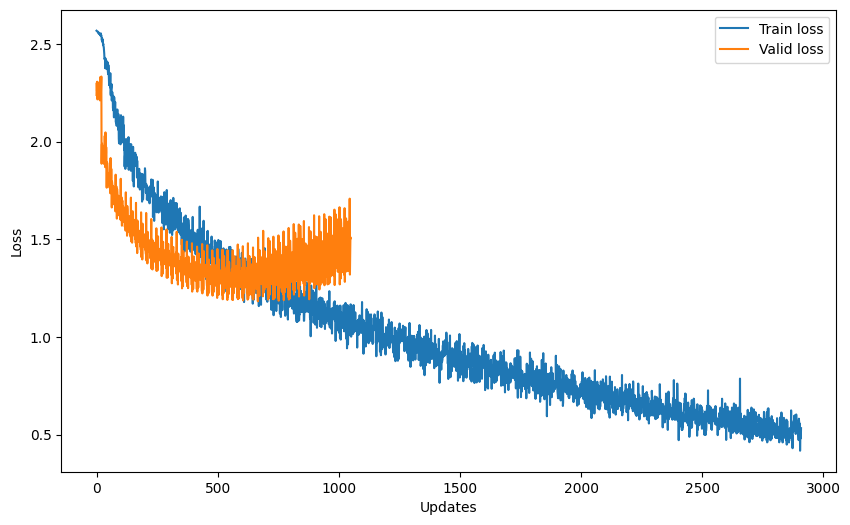

In [32]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='Train loss')
ax.plot(valid_losses, label='Valid loss')
plt.legend()
ax.set_xlabel('Updates')
ax.set_ylabel('Loss')

Text(0, 0.5, 'Accuracy')

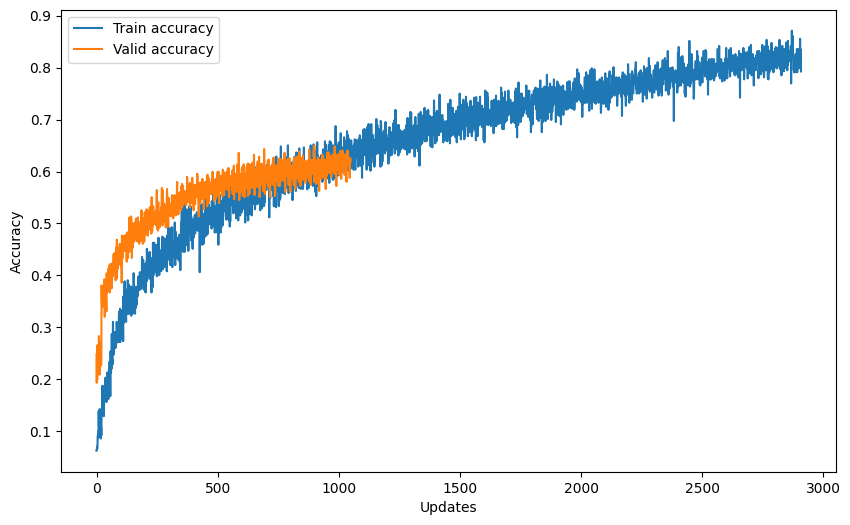

In [33]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='Train accuracy')
ax.plot(valid_accs, label='Valid accuracy')
plt.legend()
ax.set_xlabel('Updates')
ax.set_ylabel('Accuracy')

In [35]:
model.load_state_dict(torch.load('models/lstm_50.pt'))

test_loss, test_acc, true_labels, predicted_labels = evaluate(test_dataloader, model, criterion, optimizer, device, class_names)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)

print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

evaluating...: 100%|██████████| 22/22 [00:02<00:00, 10.00it/s]
test_loss: 1.281, test_acc: 0.586


In [36]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = [vocab[t] for t in tokens]
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [37]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(6, 0.6931637525558472)

In [38]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(5, 0.5831499695777893)

In [39]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(10, 0.3158559799194336)

In [40]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(5, 0.44550207257270813)

### **4.1.2 GRU (Gated Recurrent Unit)**

In [41]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional,
                 dropout_rate, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional,
                            dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
      # ids = [batch size, seq len]
      # length = [batch size]
      embedded = self.dropout(self.embedding(ids))
      # embedded = [batch size, seq len, embedding dim]

      # Pack the sequence
      packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, length, batch_first=True, enforce_sorted=False)

      # GRU
      packed_output, hidden = self.gru(packed_embedded)
      # hidden = [n layers * n directions, batch size, hidden dim]

      # Unpack the sequence
      output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
      # output = [batch size, seq len, hidden dim * n directions]

      # Process the hidden state
      if self.gru.bidirectional:
          hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
          # hidden = [batch size, hidden dim * 2]
      else:
          hidden = self.dropout(hidden[-1])
          # hidden = [batch size, hidden dim]

      # Fully connected layer
      prediction = self.fc(hidden)
      # prediction = [batch size, output dim]

      return prediction

In [42]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique('label'))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = GRUModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate, pad_index)

In [43]:
vectors = torchtext.vocab.FastText()

pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

model.embedding.weight.data = pretrained_embedding

lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

In [45]:
def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_length = [i['length'] for i in batch]
    batch_length = torch.stack(batch_length)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'length': batch_length,
             'label': batch_label}
    return batch

batch_size = 512

collate = partial(collate, pad_index=pad_index)

train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               collate_fn=collate,
                                               shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

In [49]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        length = batch['length']
        label = batch['label'].to(device)

        # Adding length check
        if any(l <= 0 for l in length):
            continue  # Ignore this batch if there are zero-length sequences

        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy)

    return epoch_losses, epoch_accs

def evaluate(dataloader, model, criterion, ptimizer, device, class_names):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            length = batch['length']
            label = batch['label'].to(device)

            # Adding length check
            if any(l <= 0 for l in length):
                continue  # Ignore this batch if there are zero-length sequences

            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy)

            # Convert the predictions back to the original classes
            predicted_classes = [class_names[pred_idx] for pred_idx in prediction.argmax(dim=1).cpu().tolist()]
            true_classes = [class_names[label_idx] for label_idx in label.cpu().tolist()]

            predicted_labels.extend(predicted_classes)
            true_labels.extend(true_classes)

    return epoch_losses, epoch_accs, true_labels, predicted_labels # Return the real labels and forecasts

def get_accuracy(prediction, label):
    #Converting predictions into classes
    predicted_classes = prediction.argmax(dim=1)

    # Calculating the number of correct predictions
    correct_predictions = (predicted_classes == label).sum().item()

    # Calculating accuracy
    accuracy = correct_predictions / len(label)
    return accuracy

Epoch: 1
evaluating...: 100%|██████████| 22/22 [00:01<00:00, 11.69it/s]
Train Loss: 1.870, Train Accuracy: 0.367
Valid Loss: 1.763, Valid Accuracy: 0.407
Epoch: 2
evaluating...: 100%|██████████| 22/22 [00:00<00:00, 31.45it/s]
Train Loss: 1.742, Train Accuracy: 0.411
Valid Loss: 1.692, Valid Accuracy: 0.430
Epoch: 3
evaluating...: 100%|██████████| 22/22 [00:00<00:00, 32.26it/s]
Train Loss: 1.641, Train Accuracy: 0.444
Valid Loss: 1.627, Valid Accuracy: 0.451
Epoch: 4
evaluating...: 100%|██████████| 22/22 [00:00<00:00, 23.61it/s]
Train Loss: 1.563, Train Accuracy: 0.473
Valid Loss: 1.578, Valid Accuracy: 0.473
Epoch: 5
evaluating...: 100%|██████████| 22/22 [00:00<00:00, 32.69it/s]
Train Loss: 1.490, Train Accuracy: 0.497
Valid Loss: 1.533, Valid Accuracy: 0.485
Epoch: 6
evaluating...: 100%|██████████| 22/22 [00:00<00:00, 32.42it/s]
Train Loss: 1.438, Train Accuracy: 0.512
Valid Loss: 1.501, Valid Accuracy: 0.496
Epoch: 7
evaluating...: 100%|██████████| 22/22 [00:00<00:00, 26.48it/s]
Trai

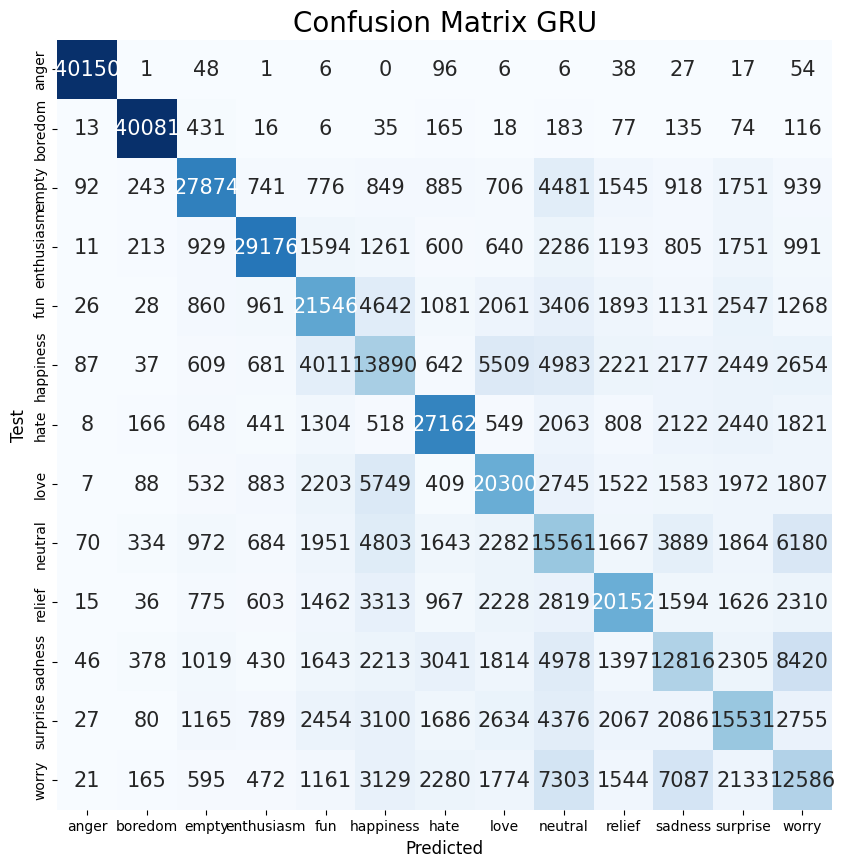

In [51]:
n_epochs = 50
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
all_true_labels = []
all_predicted_labels = []

for epoch in range(n_epochs):

    print(f'Epoch: {epoch+1}')

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc, true_labels, predicted_labels = evaluate(valid_dataloader, model, criterion, optimizer, device, class_names)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'gru_50.pt')

    all_true_labels.extend(true_labels)
    all_predicted_labels.extend(predicted_labels)

    print(f'Train Loss: {epoch_train_loss:.3f}, Train Accuracy: {epoch_train_acc:.3f}')
    print(f'Valid Loss: {epoch_valid_loss:.3f}, Valid Accuracy: {epoch_valid_acc:.3f}')

# After the training is finished, you can calculate the classification report and the confusion matrix using the true labels and predictions from all epochs
classification_report_str = classification_report(all_true_labels, all_predicted_labels)

# Print the classification report
print("Classification Report:")
print(classification_report_str)

conf_matrix(all_true_labels, all_predicted_labels, class_names, "Confusion Matrix GRU")

Text(0, 0.5, 'Loss')

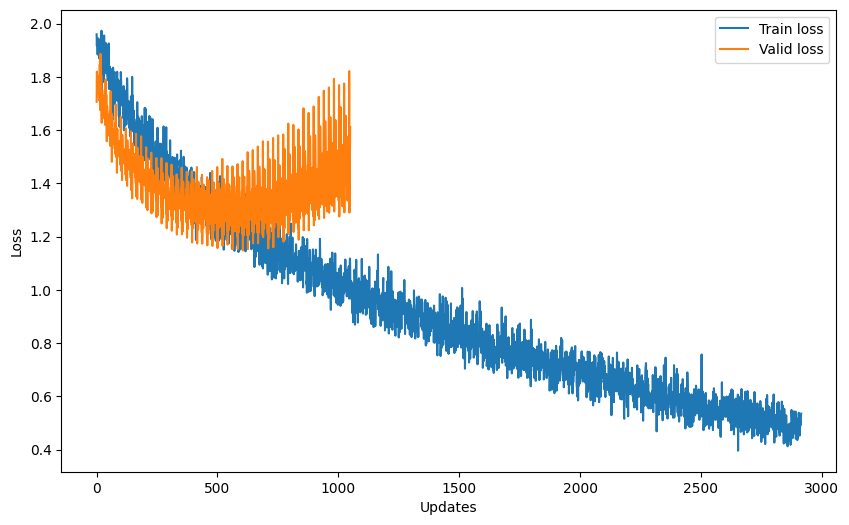

In [52]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='Train loss')
ax.plot(valid_losses, label='Valid loss')
plt.legend()
ax.set_xlabel('Updates')
ax.set_ylabel('Loss')

Text(0, 0.5, 'Accuracy')

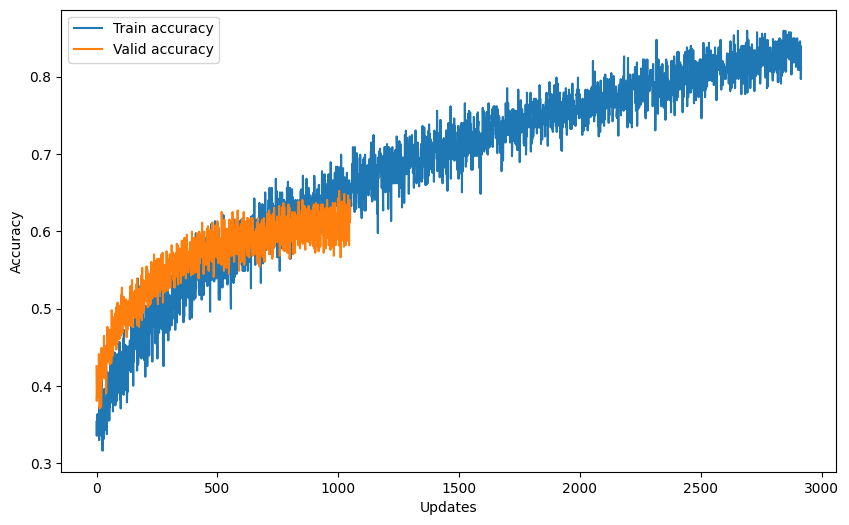

In [53]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='Train accuracy')
ax.plot(valid_accs, label='Valid accuracy')
plt.legend()
ax.set_xlabel('Updates')
ax.set_ylabel('Accuracy')

In [56]:
model.load_state_dict(torch.load('models/gru_50.pt'))

test_loss, test_acc, true_labels, predicted_labels = evaluate(test_dataloader, model, criterion, optimizer, device, class_names)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)

print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

evaluating...: 100%|██████████| 22/22 [00:01<00:00, 16.59it/s]
test_loss: 1.301, test_acc: 0.580


In [57]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(6, 0.6868496537208557)

In [58]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(5, 0.5880870819091797)

In [59]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(10, 0.3685967028141022)

In [60]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(5, 0.3394429683685303)

## **4.2 Pre-trained Transformers: Maximizing the Potential of Transfer Learning**

### **4.2.1 BERT (Bidirectional Encoder Representations from Transformers)**

In [61]:
def tokenize_and_numericalize_data(example, tokenizer):
    ids = tokenizer(example['text'], truncation=True)['input_ids']
    return {'ids': ids}

transformer_name = 'bert-base-uncased'

transformer = AutoModel.from_pretrained(transformer_name)

transformer.config.hidden_size

tokenizer = AutoTokenizer.from_pretrained(transformer_name)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [65]:
# Renaming columns and preparing data for training and testing
df_train.rename(columns={'content': 'text', 'sentiment': 'label'}, inplace=True)
df_test.rename(columns={'content': 'text', 'sentiment': 'label'}, inplace=True)
df_val.rename(columns={'content': 'text', 'sentiment': 'label'}, inplace=True)

label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['label'])
df_test['label'] = label_encoder.transform(df_test['label'])
df_val['label'] = label_encoder.transform(df_val['label'])


df_train_dict = {
    "text": df_train['text'].tolist(),
    "label": df_train['label'].tolist()
}

df_test_dict = {
    "text": df_test['text'].tolist(),
    "label": df_test['label'].tolist()
}

df_val_dict = {
    "text": df_val['text'].tolist(),
    "label": df_val['label'].tolist()
}

train_data = Dataset.from_dict(df_train_dict)
test_data = Dataset.from_dict(df_test_dict)
valid_data = Dataset.from_dict(df_val_dict)

In [66]:
df_train['ids'] = df_train['text'].apply(lambda x: tokenizer(x)['input_ids'])
df_test['ids'] = df_test['text'].apply(lambda x: tokenizer(x)['input_ids'])
df_val['ids'] = df_val['text'].apply(lambda x: tokenizer(x)['input_ids'])

train_data = train_data.map(tokenize_and_numericalize_data, fn_kwargs={'tokenizer': tokenizer})
test_data = test_data.map(tokenize_and_numericalize_data, fn_kwargs={'tokenizer': tokenizer})
valid_data = valid_data.map(tokenize_and_numericalize_data, fn_kwargs={'tokenizer': tokenizer})


train_data = train_data.with_format(type='torch', columns=['ids', 'label'])
valid_data = valid_data.with_format(type='torch', columns=['ids', 'label'])
test_data = test_data.with_format(type='torch', columns=['ids', 'label'])

Map:   0%|          | 0/44096 [00:00<?, ? examples/s]

Map:   0%|          | 0/11024 [00:00<?, ? examples/s]

Map:   0%|          | 0/13780 [00:00<?, ? examples/s]

In [67]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)

        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        # ids = [batch size, seq len]
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        # hidden = [batch size, seq len, hidden dim]
        attention = output.attentions[-1]
        # attention = [batch size, n heads, seq len, seq len]
        cls_hidden = hidden[:,0,:]
        prediction = self.fc(torch.tanh(cls_hidden))
        # prediction = [batch size, output dim]
        return prediction

In [68]:
output_dim = len(train_data['label'].unique())
freeze = False

model = Transformer(transformer, output_dim, freeze)

In [69]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 109,492,237 trainable parameters


In [70]:
lr = 1e-5

optimizer = optim.Adam(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

In [71]:
def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'label': batch_label}
    return batch

In [72]:
pad_index = tokenizer.pad_token_id

batch_size = 8

collate = functools.partial(collate, pad_index=pad_index)

train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               collate_fn=collate,
                                               shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

In [73]:
def train(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        label = batch['label'].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [74]:
def evaluate(dataloader, model, criterion, device, class_names):

    model.eval()
    epoch_losses = []
    epoch_accs = []
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            label = batch['label'].to(device)

            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

            # Convert the predictions back to the original classes
            predicted_classes = [class_names[pred_idx] for pred_idx in prediction.argmax(dim=1).cpu().tolist()]
            true_classes = [class_names[label_idx] for label_idx in label.cpu().tolist()]

            predicted_labels.extend(predicted_classes)
            true_labels.extend(true_classes)

    return epoch_losses, epoch_accs, true_labels, predicted_labels

In [75]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [ ]:
n_epochs = 50
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
all_true_labels = []
all_predicted_labels = []

for epoch in range(n_epochs):

    print(f'Epoch: {epoch+1}')

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc, true_labels, predicted_labels = evaluate(valid_dataloader, model, criterion, device, class_names)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'bert_50.pt')

    all_true_labels.extend(true_labels)
    all_predicted_labels.extend(predicted_labels)

    print(f'Train Loss: {epoch_train_loss:.3f}, Train Accuracy: {epoch_train_acc:.3f}')
    print(f'Valid Loss: {epoch_valid_loss:.3f}, Valid Accuracy: {epoch_valid_acc:.3f}')

# After the training is finished, you can calculate the classification report and the confusion matrix using the true labels and predictions from all epochs
classification_report_str = classification_report(all_true_labels, all_predicted_labels)

# Print the classification report
print("Classification Report:")
print(classification_report_str)

conf_matrix(all_true_labels, all_predicted_labels, class_names, "Confusion Matrix Bert")

Epoch: 1
training...:   0%|          | 0/5512 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


evaluating...: 100%|██████████| 1723/1723 [00:25<00:00, 67.17it/s]
Train Loss: 1.913, Train Accuracy: 0.357
Valid Loss: 1.564, Valid Accuracy: 0.478
Epoch: 2
evaluating...: 100%|██████████| 1723/1723 [00:25<00:00, 67.16it/s]
Train Loss: 1.331, Train Accuracy: 0.557
Valid Loss: 1.347, Valid Accuracy: 0.563
Epoch: 3
evaluating...: 100%|██████████| 1723/1723 [00:29<00:00, 57.94it/s]
Train Loss: 0.909, Train Accuracy: 0.696
Valid Loss: 1.119, Valid Accuracy: 0.642
Epoch: 4
evaluating...: 100%|██████████| 1723/1723 [00:30<00:00, 56.05it/s]
Train Loss: 0.631, Train Accuracy: 0.787
Valid Loss: 1.084, Valid Accuracy: 0.674
Epoch: 5
evaluating...: 100%|██████████| 1723/1723 [00:25<00:00, 67.32it/s]
Train Loss: 0.446, Train Accuracy: 0.848
Valid Loss: 1.100, Valid Accuracy: 0.686
Epoch: 6
evaluating...: 100%|██████████| 1723/1723 [00:29<00:00, 57.69it/s]
Train Loss: 0.310, Train Accuracy: 0.895
Valid Loss: 1.167, Valid Accuracy: 0.698
Epoch: 7
evaluating...: 100%|██████████| 1723/1723 [00:30<00:

Text(0, 0.5, 'Loss')

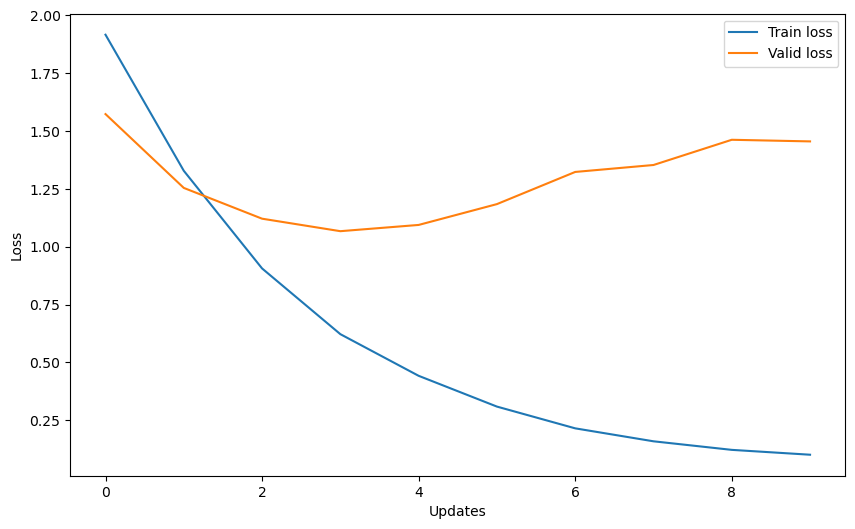

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='Train loss')
ax.plot(valid_losses, label='Valid loss')
plt.legend()
ax.set_xlabel('Updates')
ax.set_ylabel('Loss')

Text(0, 0.5, 'Accuracy')

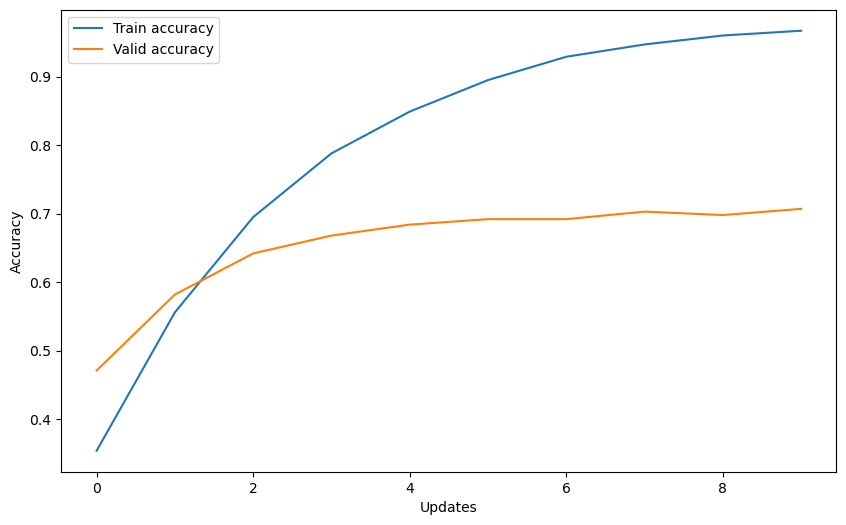

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='Train accuracy')
ax.plot(valid_accs, label='Valid accuracy')
plt.legend()
ax.set_xlabel('Updates')
ax.set_ylabel('Accuracy')

In [ ]:
model.load_state_dict(torch.load('models/bert.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)

print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

evaluating...:   0%|          | 0/1378 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


evaluating...: 100%|██████████| 1378/1378 [14:19<00:00,  1.60it/s]
test_loss: 2.310, test_acc: 0.385


In [ ]:
def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text)['input_ids']
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [ ]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, device)

(6, 0.9805049300193787)

In [ ]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, device)

(5, 0.7486068606376648)

In [ ]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, device)

(5, 0.6659852266311646)

In [ ]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, device)

(6, 0.980614423751831)

### **4.2.2 BERT with Weighted Classes**

In [ ]:
def tokenize_and_numericalize_data(example, tokenizer):
    ids = tokenizer(example['text'], truncation=True)['input_ids']
    return {'ids': ids}

transformer_name = 'bert-base-uncased'

transformer = AutoModel.from_pretrained(transformer_name)

transformer.config.hidden_size

tokenizer = AutoTokenizer.from_pretrained(transformer_name)

In [ ]:
def tokenize_and_numericalize_data(example, tokenizer):
    ids = tokenizer(example['text'], truncation=True)['input_ids']
    return {'ids': ids}

transformer_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(transformer_name)

In [ ]:
# Renaming columns and preparing data for training and testing

df_train.rename(columns={'content': 'text', 'sentiment': 'label'}, inplace=True)
df_test.rename(columns={'content': 'text', 'sentiment': 'label'}, inplace=True)
df_val.rename(columns={'content': 'text', 'sentiment': 'label'}, inplace=True)

label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['label'])
df_test['label'] = label_encoder.transform(df_test['label'])
df_val['label'] = label_encoder.transform(df_val['label'])


df_train_dict = {
    "text": df_train['text'].tolist(),
    "label": df_train['label'].tolist()
}

df_test_dict = {
    "text": df_test['text'].tolist(),
    "label": df_test['label'].tolist()
}

df_val_dict = {
    "text": df_val['text'].tolist(),
    "label": df_val['label'].tolist()
}

train_data = Dataset.from_dict(df_train_dict)
test_data = Dataset.from_dict(df_test_dict)
valid_data = Dataset.from_dict(df_val_dict)

In [ ]:
df_train['ids'] = df_train['text'].apply(lambda x: tokenizer(x)['input_ids'])
df_test['ids'] = df_test['text'].apply(lambda x: tokenizer(x)['input_ids'])
df_val['ids'] = df_val['text'].apply(lambda x: tokenizer(x)['input_ids'])

train_data = train_data.map(tokenize_and_numericalize_data, fn_kwargs={'tokenizer': tokenizer})
test_data = test_data.map(tokenize_and_numericalize_data, fn_kwargs={'tokenizer': tokenizer})
valid_data = valid_data.map(tokenize_and_numericalize_data, fn_kwargs={'tokenizer': tokenizer})


train_data = train_data.with_format(type='torch', columns=['ids', 'label'])
valid_data = valid_data.with_format(type='torch', columns=['ids', 'label'])
test_data = test_data.with_format(type='torch', columns=['ids', 'label'])

Map:   0%|          | 0/25600 [00:00<?, ? examples/s]

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [ ]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)

        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        # ids = [batch size, seq len]
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        # hidden = [batch size, seq len, hidden dim]
        attention = output.attentions[-1]
        # attention = [batch size, n heads, seq len, seq len]
        cls_hidden = hidden[:,0,:]
        prediction = self.fc(torch.tanh(cls_hidden))
        # prediction = [batch size, output dim]
        return prediction

In [ ]:
output_dim = len(train_data['label'].unique())
freeze = False

model = Transformer(transformer, output_dim, freeze)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
#compute the class weights
train_labels = df_train['label'].tolist()
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print('Class Weights:',class_weights)

In [ ]:
lr = 1e-5

# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

optimizer = optim.AdamW(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss(weight=weights)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'label': batch_label}
    return batch

In [ ]:
pad_index = tokenizer.pad_token_id

batch_size = 8

collate = functools.partial(collate, pad_index=pad_index)

train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               collate_fn=collate,
                                               shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [ ]:
def evaluate(dataloader, model, criterion, device):

    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            label = batch['label'].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [ ]:
def train(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        label = batch['label'].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [ ]:
n_epochs = 10
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), '/content/transformer_model.pt')

    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

### **4.2.3 RoBERTa**

In [ ]:
tf = TfidfVectorizer(analyzer='word', max_features=1000, ngram_range=(1,3))

In [ ]:
# category to binary
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()
y_valid = encoder.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
labels = np.unique(encoder.inverse_transform(y_train))

In [ ]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained('cardiffnlp/twitter-roberta-base-emotion')

is_train=True

In [ ]:
#Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train, X_test, y_train, y_test = train_test_split(df_train['content'], df_train['sentiment'], test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

#Oversample the minority classes using RandomOverSampler
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns=['content', 'sentiment'])

#Encode the labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_valid_encoded = encoder.transform(np.array(y_valid).reshape(-1, 1))
y_test_encoded = encoder.transform(np.array(y_test).reshape(-1, 1))

#Tokenize the input data
tokenizer = RobertaTokenizerFast.from_pretrained('cardiffnlp/twitter-roberta-base-emotion')
MAX_LEN = 128

class EmotionsDataset(Dataset):
    def __init__(self, data, labels, tokenizer, max_len):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt',
            truncation=True
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

train_dataset = EmotionsDataset(train_os['content'].values, y_train_encoded, tokenizer, MAX_LEN)
valid_dataset = EmotionsDataset(X_valid.values, y_valid_encoded, tokenizer, MAX_LEN)
test_dataset = EmotionsDataset(X_test.values, y_test_encoded, tokenizer, MAX_LEN)

#Create data loaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

#Create the RoBERTa model
roberta_model = RobertaModel.from_pretrained('cardiffnlp/twitter-roberta-base-emotion').to(device)

#Create the classification model
class EmotionClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(EmotionClassifier, self).__init__()
        self.bert_model = bert_model
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(bert_model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits

#Set hyperparameters
num_classes = len(encoder.classes_)
lr = 2e-5
num_epochs = 4

#Initialize the classifier
classifier = EmotionClassifier(roberta_model, num_classes).to(device)

if is_train:
    #Set optimizer and loss function
    optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    #Training loop
    for epoch in range(num_epochs):
        classifier.train()
        train_loss = 0.0
        train_correct = 0
        total = 0

        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = classifier(input_ids, attention_mask)
            _, predicted = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_loss += loss.item()

            if batch_idx % 100 == 0:
                batch_acc = train_correct / total
                batch_loss = train_loss / (batch_idx + 1)
                print(f"Epoch {epoch + 1}/{num_epochs} | Batch {batch_idx}/{len(train_loader)} | Loss: {batch_loss:.4f} | Accuracy: {batch_acc:.4f}")

        train_accuracy = train_correct / total
        train_loss /= len(train_loader)
    torch.save(classifier.state_dict(), 'models/roberta.pth')

classifier.load_state_dict(torch.load('models/roberta.pth', map_location=device))
# Validation
classifier.eval()
valid_loss = 0.0
valid_correct = 0
total = 0

with torch.no_grad():
    for batch in valid_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = classifier(input_ids, attention_mask)
        _, predicted = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)

        total += labels.size(0)
        valid_correct += (predicted == labels).sum().item()

        valid_loss += loss.item()

    valid_accuracy = valid_correct / total
    valid_loss /= len(valid_loader)

# Print training and validation results
print(f'Epoch {epoch + 1}/{num_epochs}')
print(f'Training Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}')
print(f'Validation Loss: {valid_loss:.4f} | Validation Accuracy: {valid_accuracy:.4f}')
print('------------------------------------------')
#Testing
classifier.eval()
test_loss = 0.0
test_correct = 0
total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)


        outputs = classifier(input_ids, attention_mask)
        _, predicted = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)

        total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        test_loss += loss.item()

        predictions.extend(predicted.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

    test_accuracy = test_correct / total
    test_loss /= len(test_loader)

#Print test results
print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}')

#Convert predictions and true labels back to original labels
predicted_labels = encoder.inverse_transform(predictions)
true_labels = encoder.inverse_transform(true_labels)

#Calculate classification metrics
classification_metrics = classification_report(true_labels, predicted_labels)

print('Classification Report:')
print(classification_metrics)

conf_matrix(true_labels, predicted_labels, class_names, "Confusion Matrix RoBERTa")

### **4.2.4 GPT2**

In [ ]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
gpt2 = GPT2Model.from_pretrained(model_name)

In [ ]:
token_lengths = dfaug['content'].apply(lambda x: len(tokenizer.encode(x)))
average_token_length = token_lengths.mean()
print(f"Average length in tokens: {average_token_length}")

In [ ]:
# split train dataset into train, validation and test sets
aug_train_text, aug_temp_text, aug_train_labels, aug_temp_labels = train_test_split(dfaug['content'], dfaug['sentiment'],
                                                                    random_state=42,
                                                                    test_size=0.3,
                                                                    stratify=dfaug['sentiment'])


aug_val_text, aug_test_text, aug_val_labels, aug_test_labels = train_test_split(aug_temp_text, aug_temp_labels,
                                                                random_state=42,
                                                                test_size=0.5,
                                                                stratify=aug_temp_labels)

print("Train set size : ", aug_train_text.shape)
print("Test set size : ", aug_test_text.shape)
print("Validation set size : ", aug_val_text.shape)

In [ ]:
#Encoding labels
encoder = LabelEncoder()
aug_train_labels = encoder.fit_transform(aug_train_labels)
aug_val_labels = encoder.transform(aug_val_labels)
aug_test_labels = encoder.transform(aug_test_labels)

In [ ]:
# Set the padding token
tokenizer.pad_token = tokenizer.eos_token

def tokenize_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=20, return_tensors="pt")

train_encodings = tokenize_texts(aug_train_text.tolist())
val_encodings = tokenize_texts(aug_val_text.tolist())
test_encodings = tokenize_texts(aug_test_text.tolist())

In [ ]:
for param in gpt2.parameters():
    param.requires_grad = False

In [ ]:
class GPT2ForSentimentAnalysis(nn.Module):
    def __init__(self, gpt2_model, num_labels):
        super().__init__()
        self.gpt2 = gpt2_model
        self.dropout = nn.Dropout(p=0.2)
        self.intermediate = nn.Linear(gpt2_model.config.n_embd, gpt2_model.config.n_embd)
        self.activation = nn.ReLU()
        # self.activation = nn.GELU()
        self.batch_norm = nn.BatchNorm1d(gpt2_model.config.n_embd)
        self.classifier = nn.Linear(gpt2_model.config.n_embd, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state

        # Apply average pooling
        pooled_output = torch.mean(sequence_output, dim=1)

        # pooled_output = torch.mean(pooled_output, 1)  # For average pooling
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.intermediate(pooled_output)
        pooled_output = self.activation(pooled_output)
        pooled_output = self.batch_norm(pooled_output)
        logits = self.classifier(pooled_output)

        return logits

In [ ]:
num_labels = 13  # Adjust based on your task
model = GPT2ForSentimentAnalysis(gpt2, num_labels)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_trainable_params = count_trainable_parameters(model)
print(f"Total trainable parameters: {total_trainable_params}")

In [ ]:
#THIS IS A SIMPLE MODEL FOR SENTIMENT ANALYSIS USING GPT2 - DO NOT USE THIS FOR PRODUCTION
##THESE RESULTS COULD BE DOCUMENTED IN THE REPORT
class GPT2ForSentimentAnalysis(nn.Module):
    def __init__(self, gpt2_model, num_labels):
        super().__init__()
        self.gpt2 = gpt2_model
        self.classifier = nn.Linear(gpt2_model.config.n_embd, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        # Use the representation of the [CLS] token or average pooling
        logits = self.classifier(sequence_output[:, 0, :])  # for [CLS] token
        # logits = self.classifier(torch.mean(sequence_output, 1))  # for average pooling
        return logits

num_labels = 13  # Adjust based on your task
model = GPT2ForSentimentAnalysis(gpt2, num_labels)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
batch_size=32

train_seq = torch.tensor(train_encodings['input_ids'])
train_mask = torch.tensor(train_encodings['attention_mask'])
train_y = torch.tensor(aug_train_labels)

val_seq = torch.tensor(val_encodings['input_ids'])
val_mask = torch.tensor(val_encodings['attention_mask'])
val_y = torch.tensor(aug_val_labels)

# Create TensorDatasets
train_data = TensorDataset(train_seq, train_mask, train_y)
val_data = TensorDataset(val_seq, val_mask, val_y)

# Create Samplers
train_sampler = RandomSampler(train_data)
val_sampler = SequentialSampler(val_data)

# Create DataLoaders
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_loader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
# Check the first 5 batches of the training DataLoader
print("Training DataLoader:")
for i, batch in enumerate(train_loader):
    if i < 5:  # Check only the first 5 batches
        print(f"\nBatch {i+1}:")
        print(f"Input IDs: {batch[0]}")  # train_seq
        print(f"Attention Mask: {batch[1]}")  # train_mask
        print(f"Labels: {batch[2]}")  # train_y
    else:
        break

# Check the first 5 batches of the validation DataLoader
print("\nValidation DataLoader:")
for i, batch in enumerate(val_loader):
    if i < 5:  # Check only the first 5 batches
        print(f"\nBatch {i+1}:")
        print(f"Input IDs: {batch[0]}")  # val_seq
        print(f"Attention Mask: {batch[1]}")  # val_mask
        print(f"Labels: {batch[2]}")  # val_y
    else:
        break


In [ ]:
# define the optimizer
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)

# Loss function (without class weights)
criterion = nn.CrossEntropyLoss()

In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def trainGPT(model, dataloader, optimizer, criterion, device):
    model.to(device)
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm(dataloader, desc='Training...', file=sys.stdout):
        input_ids, attention_mask, labels = batch  # Unpack the batch

        # Move tensors to the specified device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = model(input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)

        # Calculate accuracy
        accuracy = get_accuracy(logits, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record loss and accuracy
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [ ]:
def evaluateGPT(model, dataloader, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []


    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", file=sys.stdout):
            input_ids, attention_mask, labels = batch  # Unpack the batch

            # Move tensors to the specified device
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            logits = model(input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)
           #total_loss += loss.item()

            # Calculate accuracy
            accuracy = get_accuracy(logits, labels)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())


    return epoch_losses, epoch_accs

In [ ]:
n_epochs = 10
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = trainGPT(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluateGPT(model, val_loader, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), '/content/transformer_model.pt')

    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

## **4.3 Transformer from Scratch**

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
src_vocab_size = tokenizer.vocab_size

In [ ]:
def tokenize_and_numericalize_data(example, tokenizer):
    ids = tokenizer(example['text'], truncation=True)['input_ids']
    return {'ids': ids}

In [ ]:
#Split df into train, test and validation
X = df['content']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123, stratify=y_train)

print("Train set size : ", X_train.shape)
print("Test set size : ", X_test.shape)
print("Validation set size : ", X_val.shape)

# Rebuilding the DataFrames
df_train = pd.DataFrame({'content': X_train, 'sentiment': y_train})
df_test = pd.DataFrame({'content': X_val, 'sentiment': y_val})
df_val = pd.DataFrame({'content': X_test, 'sentiment': y_test})

Train set size :  (25600,)
Test set size :  (8000,)
Validation set size :  (6400,)


In [ ]:
# Renaming columns and preparing data for training and testing

df_train.rename(columns={'content': 'text', 'sentiment': 'label'}, inplace=True)
df_test.rename(columns={'content': 'text', 'sentiment': 'label'}, inplace=True)
df_val.rename(columns={'content': 'text', 'sentiment': 'label'}, inplace=True)

label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['label'])
df_test['label'] = label_encoder.transform(df_test['label'])
df_val['label'] = label_encoder.transform(df_val['label'])


df_train_dict = {
    "text": df_train['text'].tolist(),
    "label": df_train['label'].tolist()
}

df_test_dict = {
    "text": df_test['text'].tolist(),
    "label": df_test['label'].tolist()
}

df_val_dict = {
    "text": df_val['text'].tolist(),
    "label": df_val['label'].tolist()
}

train_data = Dataset.from_dict(df_train_dict)
test_data = Dataset.from_dict(df_test_dict)
valid_data = Dataset.from_dict(df_val_dict)

In [ ]:
max_length = 128  # Adjust based on your requirement

def tokenize_and_pad(text):
    tokenized = tokenizer.encode_plus(
        text,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    return tokenized['input_ids'][0]

df_train['input_ids'] = df_train['text'].apply(tokenize_and_pad)
df_val['input_ids'] = df_val['text'].apply(tokenize_and_pad)


In [ ]:
df_train['ids'] = df_train['text'].apply(lambda x: tokenizer(x)['input_ids'])
df_test['ids'] = df_test['text'].apply(lambda x: tokenizer(x)['input_ids'])
df_val['ids'] = df_val['text'].apply(lambda x: tokenizer(x)['input_ids'])

train_data = train_data.map(tokenize_and_numericalize_data, fn_kwargs={'tokenizer': tokenizer})
test_data = test_data.map(tokenize_and_numericalize_data, fn_kwargs={'tokenizer': tokenizer})
valid_data = valid_data.map(tokenize_and_numericalize_data, fn_kwargs={'tokenizer': tokenizer})


train_data = train_data.with_format(type='torch', columns=['ids', 'label'])
valid_data = valid_data.with_format(type='torch', columns=['ids', 'label'])
test_data = test_data.with_format(type='torch', columns=['ids', 'label'])

Map:   0%|          | 0/25600 [00:00<?, ? examples/s]

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [ ]:
def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'label': batch_label}
    return batch

In [ ]:
# Assuming you have a collate function similar to before
def collate(batch):
    batch_ids = [item['input_ids'] for item in batch]
    batch_labels = [item['label'] for item in batch]
    batch_ids = torch.stack(batch_ids)
    batch_labels = torch.tensor(batch_labels)
    return {'input_ids': batch_ids, 'labels': batch_labels}

train_dataloader = DataLoader(df_train, batch_size=8, collate_fn=collate, shuffle=True)
valid_dataloader = DataLoader(df_val, batch_size=8, collate_fn=collate)


In [ ]:
pad_index = tokenizer.pad_token_id

batch_size = 8

collate = functools.partial(collate, pad_index=pad_index)

train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               collate_fn=collate,
                                               shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [ ]:
class TransformerForSentimentAnalysis(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout, num_labels):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_labels)

    def forward(self, src):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)

        src_embedded = self.dropout(self.positional_encoding(self.embedding(src)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        # Here, using the output corresponding to the first token (similar to BERT's [CLS])
        pooled_output = enc_output[:, 0, :]
        logits = self.classifier(pooled_output)
        return logits


In [ ]:
src_vocab_size = tokenizer.vocab_size  # Use the tokenizer's vocabulary size
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 128
dropout = 0.1
num_labels=13

# Initialize the Transformer model (adapted for sentiment analysis)
transformer = TransformerForSentimentAnalysis(src_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout, num_labels)
transformer.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [ ]:
def evaluatet(dataloader, model, criterion, device):

    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            label = batch['label'].to(device)
            prediction = model(ids)
            loss = criterion(prediction.view(-1, num_labels), label.view(-1))
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [ ]:
def traint(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        label = batch['label'].to(device)
        optimizer.zero_grad()
        prediction = model(ids)
        loss = criterion(prediction.view(-1, num_labels), label.view(-1))

        accuracy = get_accuracy(prediction, label)

        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [ ]:
n_epochs = 10
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = traint(train_dataloader, transformer, criterion, optimizer)
    valid_loss, valid_acc = evaluatet(valid_dataloader, transformer, criterion)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(transfomer.state_dict(), '/content/transformer_model.pt')

    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')